In [1]:
from __future__ import print_function
from pymongo import MongoClient
import configparser
from bson.objectid import ObjectId
from utils import iou, poses2boxes, pose2midpoint, distancia_midpoints, pairwise
import cv2
import numpy as np
import random
from dtw import dtw
import operator
from flask_cors import CORS, cross_origin
import base64
from raycasting import Polygon, Point, PointInPolygon
from matplotlib import pyplot as plt
import shapely
import itertools
import operator

# Cargar configuracion
config = configparser.ConfigParser()
config.read('config.ini')
mongodb_uri = config['database']['uri']
client = MongoClient(mongodb_uri)
db = client[config['database']['database']]

/home/marcelo/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import plotly.plotly as py

ImportError: No module named plotly.plotly

In [2]:
detections_collection = db[config['database']['detections_collection']]
all_detections = list(detections_collection.find())

In [4]:
from shapely.geometry import Polygon
query_points = [(458,412),(348,494),(385,621),(385,621),(473,639),(619,541),(575,456)]
query_poli = Polygon(query_points)
# query_poli = Polygon()
# query_poli.AddPoint(Point(458,412))
# query_poli.AddPoint(Point(348,494))
# query_poli.AddPoint(Point(385,621))
# query_poli.AddPoint(Point(473,639))
# query_poli.AddPoint(Point(619,541))
# query_poli.AddPoint(Point(575,456))


In [5]:
def get_empty_frame():
    img = cv2.imread('./emptycafe.png')
    for i in range(len(query_points)-1):
        p1, p2 = query_points[i], query_points[i+1]
        cv2.line(img, p1,p2, color=(255,255,255), thickness = 4)
    return img

In [6]:
POSE_BODY_25_PAIRS_RENDER = [1,8,   1,2,   1,5,   2,3,   3,4,   5,6,   6,7,   8,9,   9,10,  10,11, 8,12,  12,13, 13,14,  1,0,   0,15, 15,17,  0,16, 16,18,   14,19,19,20,14,21, 11,22,22,23,11,24]
POSE_BODY_25_COLORS_RENDER = [
        255,     0,    85, \
        255,     0,     0, \
        255,    85,     0, \
        255,   170,     0, \
        255,   255,     0, \
        170,   255,     0, \
         85,   255,     0, \
          0,   255,     0, \
        255,     0,     0, \
          0,   255,    85, \
          0,   255,   170, \
          0,   255,   255, \
          0,   170,   255, \
          0,    85,   255, \
          0,     0,   255, \
        255,     0,   170, \
        170,     0,   255, \
        255,     0,   255, \
         85,     0,   255, \
          0,     0,   255, \
          0,     0,   255, \
          0,     0,   255, \
          0,   255,   255, \
          0,   255,   255, \
          0,   255,   255 ]
def render_pose(detection, img):
    pose = np.reshape(detection['pose'], (25,2)).astype(int)
    for i in range(0,len(POSE_BODY_25_PAIRS_RENDER)-1,2):
        point_from, point_to = tuple(pose[POSE_BODY_25_PAIRS_RENDER[i]]), tuple(pose[POSE_BODY_25_PAIRS_RENDER[i+1]])
        if point_from != (0,0) and point_to != (0,0):
            color = POSE_BODY_25_COLORS_RENDER[i:i+3]
            cv2.line(img, point_from, point_to, color)

In [7]:
filtered_detections = []
for detection in all_detections:
    pose = np.reshape(detection['pose'], (25,2)).astype(int)
    bbox = poses2boxes([pose])[0]
    bbox_polygon = Polygon([(bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3])])
    intersection_area = query_poli.intersection(bbox_polygon).area
    if (intersection_area / bbox_polygon.area > 0.7): 
        filtered_detections.append(detection)
print(len(filtered_detections))

28218


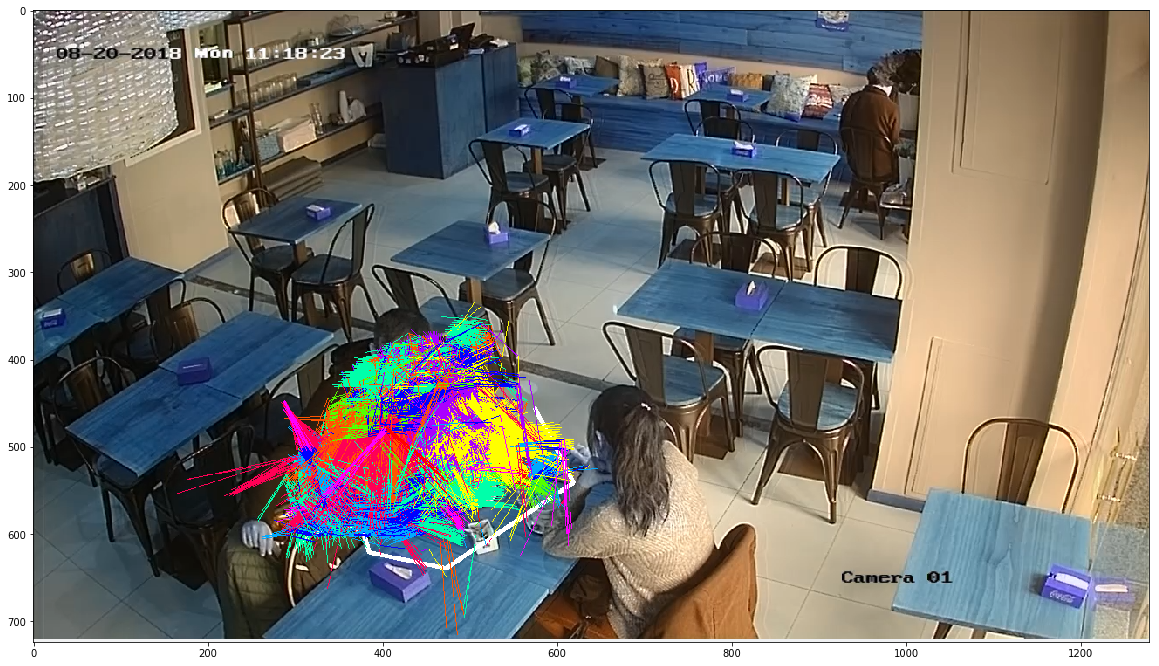

In [8]:
img = get_empty_frame()
for detection in filtered_detections:
    render_pose(detection,img)
    
    
fig2 = plt.figure(figsize = (20,20))
ax3 = fig2.add_subplot(111)
ax3.imshow(img)

In [8]:
MAX_GAP_ALLOWED = 500
MIN_DETECTIONS_REQUIRED = 300

get_pid = operator.itemgetter('pid')
detections_bypid = [list(g) for k, g in itertools.groupby(sorted(filtered_detections, key=get_pid), get_pid)]
print("Pids vistas: %s"%[e[0]['pid'] for e in detections_bypid ])

people_inarea = []
for detections_person in detections_bypid:
    pid = detections_person[0]['pid']
    print("pid %s video %s"%(pid,detections_person[0]['video']))
    detections_sortbyframe = sorted(detections_person, key = lambda det: det['frame'])
    detections_inarea = []
    for i in range(len(detections_sortbyframe)-1):
        d1, d2 = detections_sortbyframe[i], detections_sortbyframe[i+1]
        t1, t2 = d1['frame'], d2['frame']
        if t2-t1 < MAX_GAP_ALLOWED:
            detections_inarea.append(detections_sortbyframe[i])
        else:
            print("distancia de %s corta"%(t2-t1))
            print("cant dets %s"%(len(detections_inarea)))
            # Si se corta la racha de permanencia, entonces muevo la serie de detecciones seguidas
            # a la lista de resultados y empiezo de cero de vuelta
            if len(detections_inarea) > MIN_DETECTIONS_REQUIRED:
                people_inarea.append(detections_inarea)
            detections_inarea = []           
    print("can dets de %s en pid %s"%(len(detections_inarea),pid))
    if len(detections_inarea) > MIN_DETECTIONS_REQUIRED:
        people_inarea.append(detections_inarea)

Pids vistas: [2, 801, 2072, 3952, 4052, 5142, 5493, 5503, 14809, 14903, 15313]
pid 2 video ch01_20180820110000.mp4
distancia de 560 corta
cant dets 196
can dets de 6959 en pid 2
pid 801 video ch01_20180820110000.mp4
distancia de 855 corta
cant dets 7225
distancia de 530 corta
cant dets 9133
can dets de 4281 en pid 801
pid 2072 video ch01_20180820113759.mp4
can dets de 107 en pid 2072
pid 3952 video ch01_20180820113759.mp4
can dets de 14 en pid 3952
pid 4052 video ch01_20180820113759.mp4
can dets de 82 en pid 4052
pid 5142 video ch01_20180820113759.mp4
can dets de 20 en pid 5142
pid 5493 video ch01_20180820124508.mp4
can dets de 1 en pid 5493
pid 5503 video ch01_20180820124508.mp4
can dets de 62 en pid 5503
pid 14809 video ch01_20180820145929.mp4
can dets de 63 en pid 14809
pid 14903 video ch01_20180820145929.mp4
distancia de 22190 corta
cant dets 0
distancia de 7095 corta
cant dets 17
can dets de 19 en pid 14903
pid 15313 video ch01_20180820145929.mp4
can dets de 23 en pid 15313


In [9]:
for person_dets in people_inarea:
    print(person_dets[0]['pid'])

2
801
801
801


jueves:
    contar diferentes personas:
        retornar que personas y cuando entro-salio de busqueda cada una
viernes:
    en frontend:
        decir cuantas
        graficar tiempos
        graficar algo en imagen, ¿pose mas comun? ¿heatmap?
        
->dar posibilidade ver resumen de actividar de persona, relacion numeros<->personas reales vistas